In [1]:
!pip install pyspark


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.types import StringType, DoubleType, TimestampType, BooleanType, DateType, FloatType
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split



spark = SparkSession.builder.master("local[*]").appName("spark_ifood").getOrCreate()


# Preparação dos Dados

```
```



In [5]:
pedido = spark.read.json('/content/drive/MyDrive/12. Case/order.json.gz')
usuario = spark.read.csv('/content/drive/MyDrive/12. Case/consumer.csv', header=True, inferSchema=True)
restaurante = spark.read.csv('/content/drive/MyDrive/12. Case/restaurant.csv', header=True, inferSchema=True)
teste_ab = spark.read.csv('/content/drive/MyDrive/12. Case/ab_test_ref.csv', header=True,  inferSchema=True)

## Visualizandos dados carregados

In [ ]:
pedido.show()


+-----------+--------------------+-------------+---------------------+------------------------+-------------------------+----------------------------+-------------------------+--------------------------+----------------------+-------------------------+--------------------+--------------------+-----------------+------------------+-----------------+--------------------+--------------------+---------------+--------------------+------------------+---------------+
|        cpf|         customer_id|customer_name|delivery_address_city|delivery_address_country|delivery_address_district|delivery_address_external_id|delivery_address_latitude|delivery_address_longitude|delivery_address_state|delivery_address_zip_code|               items|         merchant_id|merchant_latitude|merchant_longitude|merchant_timezone|    order_created_at|            order_id|order_scheduled|order_scheduled_date|order_total_amount|origin_platform|
+-----------+--------------------+-------------+---------------------+--

In [ ]:
usuario.show()


+--------------------+--------+--------------------+------+-------------+-------------------+---------------------+
|         customer_id|language|          created_at|active|customer_name|customer_phone_area|customer_phone_number|
+--------------------+--------+--------------------+------+-------------+-------------------+---------------------+
|e8cc60860e09c0bb1...|   pt-br|2018-04-05 14:49:...|  true|         NUNO|                 46|            816135924|
|a2834a38a9876cf74...|   pt-br|2018-01-14 21:40:...|  true|     ADRIELLY|                 59|            231330577|
|41e1051728eba1334...|   pt-br|2018-01-07 03:47:...|  true|        PAULA|                 62|            347597883|
|8e7c1dcb64edf95c9...|   pt-br|2018-01-10 22:17:...|  true|       HELTON|                 13|            719366842|
|7823d4cf4150c5dae...|   pt-br|2018-04-06 00:16:...|  true|       WENDER|                 76|            543232158|
|77e6a36569f6c8f35...|   pt-br|2018-01-27 20:00:...|  true|     MICHELLE

In [ ]:
restaurante.show()

+--------------------+--------------------+-------+-----------+--------------+------------+-------------+-------------------+-----------------+--------------+--------------+----------------+
|                  id|          created_at|enabled|price_range|average_ticket|takeout_time|delivery_time|minimum_order_value|merchant_zip_code| merchant_city|merchant_state|merchant_country|
+--------------------+--------------------+-------+-----------+--------------+------------+-------------+-------------------+-----------------+--------------+--------------+----------------+
|d19ff6fca6288939b...|2017-01-23 12:52:...|  false|          3|          60.0|           0|           50|               30.0|            14025|RIBEIRAO PRETO|            SP|              BR|
|631df0985fdbbaf27...|2017-01-20 13:14:...|   true|          3|          60.0|           0|            0|               30.0|            50180|     SAO PAULO|            SP|              BR|
|135c5c4ae4c1ec1fd...|2017-01-23 12:46:...|  

In [ ]:
teste_ab.show()

+--------------------+---------+
|         customer_id|is_target|
+--------------------+---------+
|755e1fa18f25caec5...|   target|
|b821aa8372b8e5b82...|  control|
|d425d6ee4c9d4e211...|  control|
|6a7089eea0a5dc294...|   target|
|dad6b7e222bab31c0...|  control|
|82905a7d1fe78f80c...|   target|
|2c793590086a05d39...|   target|
|2c2c1ec8e79d1b98e...|   target|
|5994c3c2c48edd8a7...|   target|
|657d1330fd2b28abd...|  control|
|4ab5c66a5fbc0ccb3...|   target|
|1b669bd4b720ea0a4...|  control|
|c58d1b6ed9e7bb94a...|   target|
|5841e1fbd518d7a63...|   target|
|df4a3b2f7c0e259ad...|  control|
|d7974cdc3736cea24...|   target|
|f8dcc804aa970d381...|  control|
|fdf3cbc1ae5f2441c...|   target|
|e3c10f0f467527d2a...|  control|
|2c662e08a33f3b0c7...|   target|
+--------------------+---------+
only showing top 20 rows



## Otimização dos Tipos de Dados


### ### DataFrame Pedidos

Analisando tipo dos dados para entender possibilidade de otimização

In [ ]:
pedido.printSchema()

root
 |-- cpf: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- customer_name: string (nullable = true)
 |-- delivery_address_city: string (nullable = true)
 |-- delivery_address_country: string (nullable = true)
 |-- delivery_address_district: string (nullable = true)
 |-- delivery_address_external_id: string (nullable = true)
 |-- delivery_address_latitude: string (nullable = true)
 |-- delivery_address_longitude: string (nullable = true)
 |-- delivery_address_state: string (nullable = true)
 |-- delivery_address_zip_code: string (nullable = true)
 |-- items: string (nullable = true)
 |-- merchant_id: string (nullable = true)
 |-- merchant_latitude: string (nullable = true)
 |-- merchant_longitude: string (nullable = true)
 |-- merchant_timezone: string (nullable = true)
 |-- order_created_at: string (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_scheduled: boolean (nullable = true)
 |-- order_scheduled_date: string (nullable = true)
 |--

No processo de discovery da estrutura dos dados percebi que os tipos de algumas colunas não estavam corretos, isso dificultaria a manipulação e cálculos no futuro e para contornar isso alterei os formatos para seguir a normalização dos dados.


In [6]:
pedido = (
    pedido
    .withColumn("delivery_address_latitude", col("delivery_address_latitude").cast(FloatType()))
    .withColumn("delivery_address_longitude", col("delivery_address_longitude").cast(FloatType()))
    .withColumn("merchant_latitude", col("merchant_latitude").cast(FloatType()))
    .withColumn("merchant_longitude", col("merchant_longitude").cast(FloatType()))
    .withColumn("order_created_at", col("order_created_at").cast(TimestampType()))
    .withColumn("order_scheduled_date", col("order_scheduled_date").cast(DateType()))
    .withColumn("order_scheduled", col("order_scheduled").cast(BooleanType()))
    .withColumn("order_total_amount", col("order_total_amount").cast(DoubleType()))
)
pedido.printSchema()

root
 |-- cpf: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- customer_name: string (nullable = true)
 |-- delivery_address_city: string (nullable = true)
 |-- delivery_address_country: string (nullable = true)
 |-- delivery_address_district: string (nullable = true)
 |-- delivery_address_external_id: string (nullable = true)
 |-- delivery_address_latitude: float (nullable = true)
 |-- delivery_address_longitude: float (nullable = true)
 |-- delivery_address_state: string (nullable = true)
 |-- delivery_address_zip_code: string (nullable = true)
 |-- items: string (nullable = true)
 |-- merchant_id: string (nullable = true)
 |-- merchant_latitude: float (nullable = true)
 |-- merchant_longitude: float (nullable = true)
 |-- merchant_timezone: string (nullable = true)
 |-- order_created_at: timestamp (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_scheduled: boolean (nullable = true)
 |-- order_scheduled_date: date (nullable = true)
 |-- or

### DataFrame Usuário

Analisando tipo dos dados para entender possibilidade de otimização

In [ ]:
usuario.printSchema()

root
 |-- customer_id: string (nullable = true)
 |-- language: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- active: boolean (nullable = true)
 |-- customer_name: string (nullable = true)
 |-- customer_phone_area: integer (nullable = true)
 |-- customer_phone_number: integer (nullable = true)



Identifiquei que o DDD e o telefone estão como número e uma boa prática é deixar como string visto que não será utilizado para cálculo e também o ddd pode ter 0 a esquerda e colocar em inteiro pederia essa informação

In [7]:
usuarios = (
    usuario
    .withColumn("customer_phone_area", col("customer_phone_area").cast(StringType()))
    .withColumn("customer_phone_number", col("customer_phone_number").cast(StringType()))
)
usuarios.printSchema()

root
 |-- customer_id: string (nullable = true)
 |-- language: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- active: boolean (nullable = true)
 |-- customer_name: string (nullable = true)
 |-- customer_phone_area: string (nullable = true)
 |-- customer_phone_number: string (nullable = true)



### DataFrame Restaurante

In [ ]:
restaurante.printSchema()

root
 |-- id: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- enabled: boolean (nullable = true)
 |-- price_range: integer (nullable = true)
 |-- average_ticket: double (nullable = true)
 |-- takeout_time: integer (nullable = true)
 |-- delivery_time: integer (nullable = true)
 |-- minimum_order_value: double (nullable = true)
 |-- merchant_zip_code: integer (nullable = true)
 |-- merchant_city: string (nullable = true)
 |-- merchant_state: string (nullable = true)
 |-- merchant_country: string (nullable = true)



Idenfiquei que o merchant_zip_code está como inteiro e normalmente se trabalha com string nessa caso, pois CEP pode conter zero na esquerda. Também idenfiquei a portunidade no delivery_time e takeout_time de trabalhar com o formato doble para aumentar precisão caso necessário, para analisar a nível de segundo ou mínuto.
Outra oportunidade é trocar no do id para merchant_id para ficar mais idenficavel e também para ficar igual da tabela de pedidos.

In [8]:
restaurante = (
    restaurante
    .withColumn("delivery_time", col("delivery_time").cast(DoubleType()))
    .withColumn("takeout_time", col("takeout_time").cast(DoubleType()))
    .withColumn("merchant_zip_code", col("merchant_zip_code").cast(StringType()))
    .withColumnRenamed("id", "merchant_id")
)
restaurante.printSchema()

root
 |-- merchant_id: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- enabled: boolean (nullable = true)
 |-- price_range: integer (nullable = true)
 |-- average_ticket: double (nullable = true)
 |-- takeout_time: double (nullable = true)
 |-- delivery_time: double (nullable = true)
 |-- minimum_order_value: double (nullable = true)
 |-- merchant_zip_code: string (nullable = true)
 |-- merchant_city: string (nullable = true)
 |-- merchant_state: string (nullable = true)
 |-- merchant_country: string (nullable = true)



### DataFreme Teste AB

In [ ]:
teste_ab.printSchema()

root
 |-- customer_id: string (nullable = true)
 |-- is_target: string (nullable = true)



Não idenfiquei necessidade de alterar nada nesse dataframe

## Diagrama de Relação

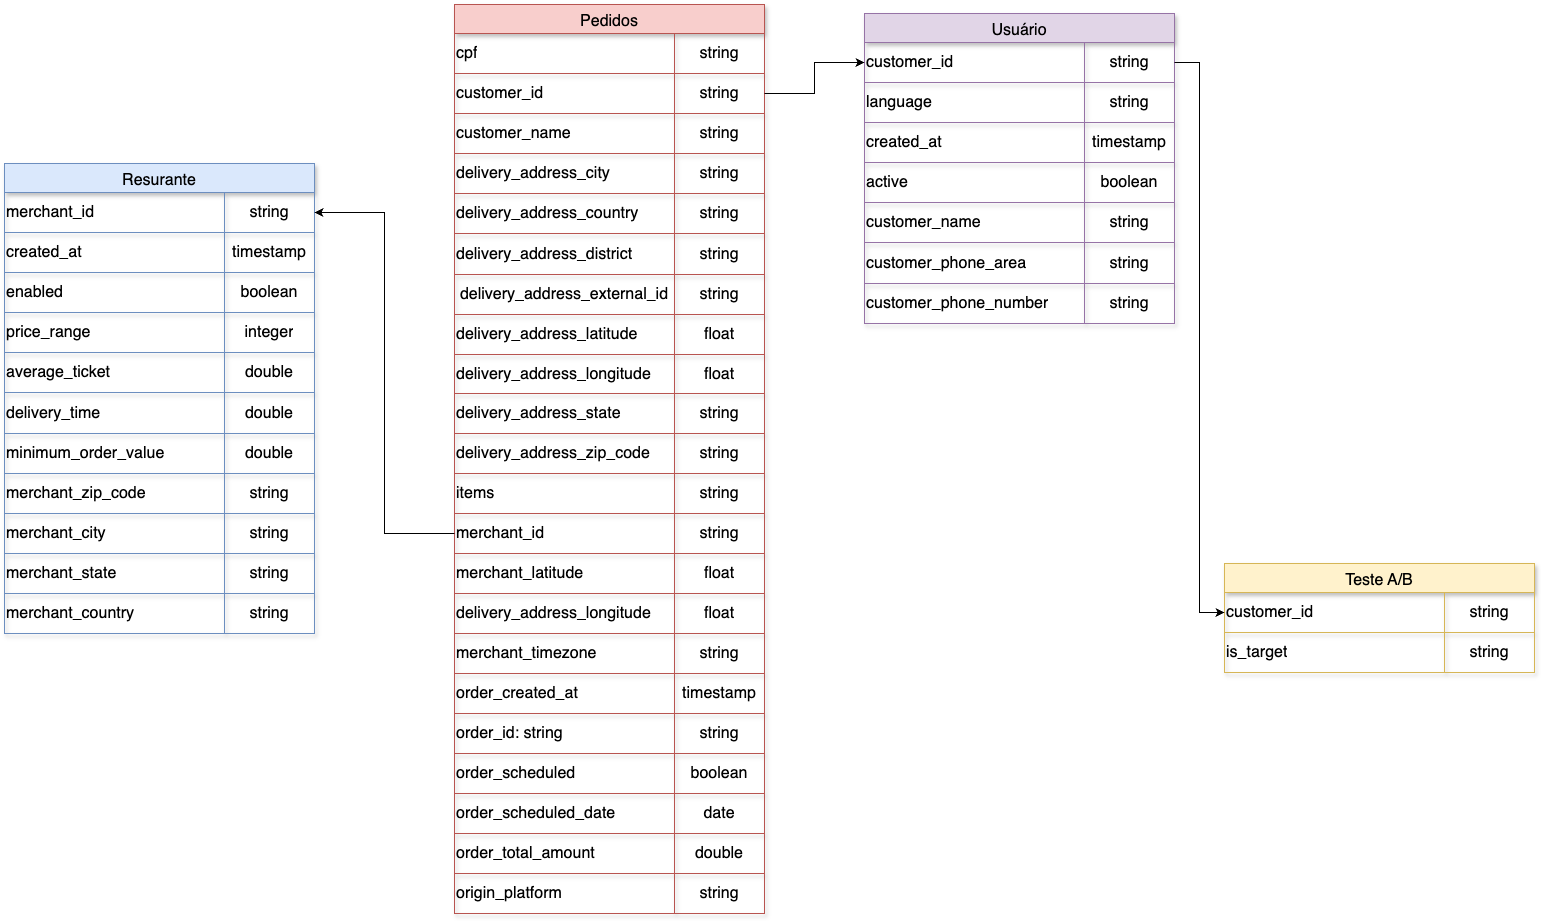

# Desafio



## 1
No iFood, várias áreas utilizam testes A/B para avaliar o impacto de
ações em diferentes métricas. Esses testes permitem validar hipóteses
de crescimento e a viabilidade de novas funcionalidades em um grupo
restrito de usuários. Nos dados fornecidos nesse case você encontrará
uma marcação de usuários, separando-os entre grupo teste e controle
de uma campanha de cupons, que disponibilizou para os usuários do
grupo teste um cupom especial.


### a) Indicadores Sucesso
Defina os indicadores relevantes para mensurar o sucesso da
campanha e analise se ela teve impacto significativo dentro do
período avaliado.


#### Indicador de receita total

Receta gerada de cada grupo(alvo e controle) para entender o impacto da campanha arrecadou mais receita para empresa vs nao ter a campanha.
Quando olhamos a receita como um todo temos o seguinte cenário grupo alvo da campanha faturou 102M equanto o grupo que nao recebeu a campanha faturou 73M, entao a campanha arreracadou 39% a mais do que nao quem nao recebeu a campanha, equivalente a 29M de saving de faturamento.
Como estamos falando de uma campanha para usuário, olhar o total de receita, pode gerar falsas conclusoes pois o grupo target conta com 445.743 usuários quanto o controle conta com 360.413, essa diferença de 85mil usuários poderia justificar a diferença de receita. Para contornar isso, vamos olhar para receita por usuário onde o grupo alvo teve uma receita de 228 por usuário enquanto o controle teve 202, sendo um acrescimo de 12,7%.

conta usuarios na pedid_ab

In [23]:
user_pedido = (
    pedido_ab
    .groupBy('is_target')
    .agg(
        countDistinct('customer_id').alias('total users')
    )
)
user_pedido.show()

+---------+-----------+
|is_target|total users|
+---------+-----------+
|  control|     360542|
|   target|     445924|
+---------+-----------+



In [9]:
# Total de pessoas que receberam a campanha
usuario_ab =usuario.join(teste_ab, how = 'inner', on = 'customer_id')

# Total de pessoas em cada grupo
user_total = (
    usuario_ab
    .groupBy('is_target')
    .agg(
        countDistinct('customer_id').alias('total users')
    )
)
user_target = (
    usuario_ab
    .filter(col('is_target') == 'target')
    .groupBy('is_target')
    .agg(
        countDistinct('customer_id').alias('total users')
    )
)

user_control = (
    usuario_ab
    .filter(col('is_target') == 'control')
    .groupBy('is_target')
    .agg(
        countDistinct('customer_id').alias('total users')
    )
)


user_target_pd = user_target.toPandas()
user_control_pd = user_control.toPandas()
user_total_pd = user_total.toPandas()



In [ ]:
print(user_total.show())

+---------+-----------+
|is_target|total users|
+---------+-----------+
|  control|     360413|
|   target|     445743|
+---------+-----------+

None


In [10]:
# Trazendo a informacao de target da camapnha pra tabela de pedidos
pedido_ab =pedido.join(teste_ab, how = 'inner', on = 'customer_id')

# Receita total

vlr_total = (
  pedido_ab
  .groupBy('is_target')
  .agg(
      format_number(sum('order_total_amount'),2)
      .alias('total_receita')
      )
)

# Somando a receita para o grupo target
vlr_target = (
    pedido_ab
    .filter(col('is_target') == 'target')
    .agg(sum('order_total_amount').alias('receita_target'))
)

# Somando a receita para o grupo control
vlr_control = (
    pedido_ab
    .filter(col('is_target') == 'control')
    .agg(sum('order_total_amount').alias('receita_control'))
)





In [11]:
# Convertendo para Pandas para facilitar cálculos
vlr_target_pd = vlr_target.toPandas()
vlr_control_pd = vlr_control.toPandas()
vlr_total_pd = vlr_total.toPandas()


#Calculando receita por usuario

receita_por_usuario_target = vlr_target_pd["receita_target"].iloc[0] / user_target_pd["total users"].iloc[0]
receita_por_usuario_control = vlr_control_pd["receita_control"].iloc[0] / user_control_pd["total users"].iloc[0]

print(receita_por_usuario_target)
print(receita_por_usuario_control)


228.8483943439238
202.7448312907982


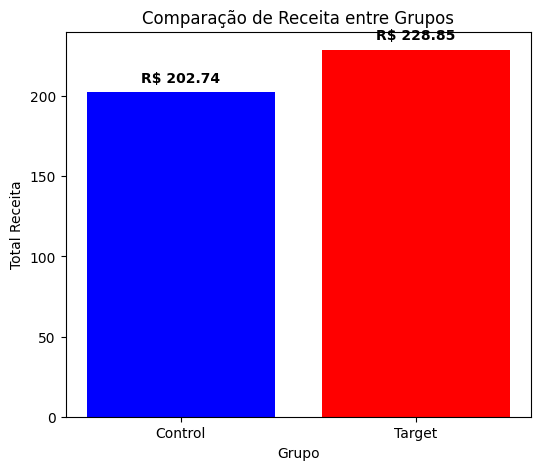

In [12]:
# Gráfico de Receita por Usuário
fig, ax = plt.subplots(figsize=(6, 5))
bars = ax.bar(["Control", "Target"], [receita_por_usuario_control, receita_por_usuario_target], color=['blue', 'red'])


for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + (yval * 0.02), f'R$ {yval:,.2f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Configurando rótulos e título
ax.set_xlabel("Grupo")
ax.set_ylabel("Total Receita")
ax.set_title("Comparação de Receita entre Grupos")

plt.show()

#### Quantidade de pedido

Analisando o volume de pedido gerados pelo grupo alvo que recebeu a caminha, idenfiquei 1.4M de pedidos versus 1M de pedidos do grupo controle, entao a campanha gerou um incremento de 40% no comportamento de compras, essa analise ainda levou em conta a forma que os grupos foram separados.
Vale a mesma ressalva feita na parte de receita, precisamos olhar o volume de pedidos por usuário para entender o impacto da campanha e quando olhamos quem recebeu a campanha fez 3,17 pedidos enquanto o grupo controle fez 2,8 pedidos, então a campanha acrescento 13,2% na quantidade de pedidos por usuário.

In [13]:
# Trazendo a informacao de target da camapnha pra tabela de pedidos
pedido_ab =pedido.join(teste_ab, how = 'inner', on = 'customer_id')

# Pedidos Gerados
vol_total = (
    pedido_ab
    .groupBy('is_target')
    .agg(
        countDistinct('order_id').alias('total_pedidos')
    )
)

# Somando a quantidade de pedidos para o grupo target
vol_target = (
    pedido_ab
    .filter(col('is_target') == 'target')
    .agg(countDistinct('order_id').alias('pedidos_target'))
)

# Somando a quantidade de pedidos para o grupo control
vol_control = (
    pedido_ab
    .filter(col('is_target') == 'control')
    .agg(countDistinct('order_id').alias('pedidos_control'))
)

# Convertendo para Pandas para facilitar cálculos

vol_target_pd = vol_target.toPandas()
vol_control_pd = vol_control.toPandas()
vol_total_pd = vol_total.toPandas()

pedidos_target_pd = vol_target_pd["pedidos_target"].iloc[0]
pedidos_control_pd = vol_control_pd["pedidos_control"].iloc[0]
pedidos_total_pd = vol_total_pd["total_pedidos"].iloc[0]

delta_volume = ((pedidos_target_pd) / pedidos_control_pd) * 100


Calculando a volume de pedidos por usuário para contornar o impacto do grupo alvo ter mais usuários do que o grupo controle

In [14]:
#Calculando quantidade de pedido por usuario

pedido_por_usuario_target = vol_target_pd["pedidos_target"].iloc[0] / user_target_pd["total users"].iloc[0]
pedido_por_usuario_control = vol_control_pd["pedidos_control"].iloc[0] / user_control_pd["total users"].iloc[0]

print(pedido_por_usuario_target)
print(pedido_por_usuario_control)


3.178237235357594
2.8043882989792266


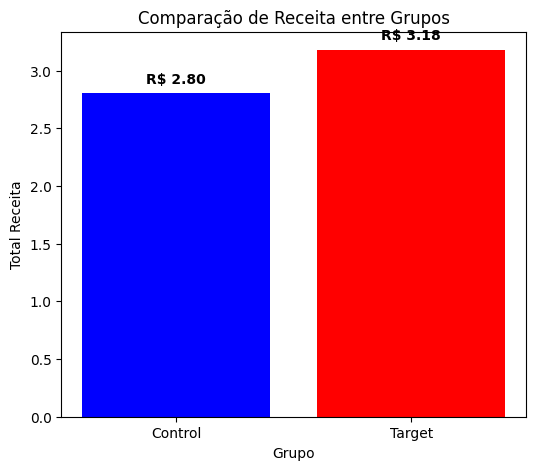

In [15]:
# Gráfico de Pedidos por Usuário
fig, ax = plt.subplots(figsize=(6, 5))
bars = ax.bar(["Control", "Target"], [pedido_por_usuario_control, pedido_por_usuario_target], color=['blue', 'red'])


for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + (yval * 0.02), f'R$ {yval:,.2f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Configurando rótulos e título
ax.set_xlabel("Grupo")
ax.set_ylabel("Total Receita")
ax.set_title("Comparação de Receita entre Grupos")

plt.show()

#### Ticket Medio

A ideia de analisar o ticket medio é entender se a campanha gerou incremento por pedido. Mesmo o impacto na receita e no volume total tenha sido grande, quando olhamos o Ticket Médio do grupo alvo ficou R$ 72 e controle ficou R$72,30, ou seja o impacto no ticket médio foi negativo, e a hipotese é que a campanha é de cupom de desconto, entao o grupo controle acaba fechando pedidos sem desconto, enquanto o grupo fecha com cupons diminuindo o ticket médio.

In [16]:
#Como já calculamos o faturamento e volume, vou usar esses cálculos para chegar no ticket médio

tkt_medio_target = vlr_target_pd / pedidos_target_pd
tkt_medio_control = vlr_control_pd / pedidos_control_pd

print(tkt_medio_target)
print(tkt_medio_control)

   receita_target
0       72.004818
   receita_control
0        72.295563


#### Retencao de usuário
Indicador importante para entendermos a penetracao da acao e se ela ajuda a deixar o usuário ativo por mais tempo, em dezembro de 2018 a açao teve uma retencao 70% no grupo  target e subiu para 100% em janeiro de 2019 enquanto o controle teve 67% de retencao em dezembro de 2018 e 100% em janeiro de 2019. Analisando esse dado, mostra que teve outro fator que trouxe os usuário e não foi a campanha, provavelmente a sazionalidade natural do negócio.

Adicionar uma coluna na tabela de pedido com mes

In [17]:
compras_por_mes = (
    pedido_ab
    .groupBy(date_format(col("order_created_at"), "yyyy-MM").alias("mes_ano"), col("is_target"))
    .agg(countDistinct("customer_id").alias("total_sers"))
    .orderBy("mes_ano")
)

compras_por_mes.show()

# Adicionar % retencao
compras_por_mes = compras_por_mes.withColumn(
    "percentual_sers",
    when(col("is_target") == "target", col("total_sers") / 445743)
    .when(col("is_target") == "control", col("total_sers") / 360413)
)

# Mostrar resultado
compras_por_mes.show()


+-------+---------+----------+
|mes_ano|is_target|total_sers|
+-------+---------+----------+
|2018-12|   target|    313049|
|2018-12|  control|    241546|
|2019-01|   target|    445924|
|2019-01|  control|    360542|
+-------+---------+----------+

+-------+---------+----------+------------------+
|mes_ano|is_target|total_sers|   percentual_sers|
+-------+---------+----------+------------------+
|2018-12|   target|    313049|0.7023082807806292|
|2018-12|  control|    241546|0.6701922516668377|
|2019-01|   target|    445924|1.0004060635837242|
|2019-01|  control|    360542|1.0003579227164392|
+-------+---------+----------+------------------+



### b) Faça uma análise de viabilidade financeira dessa iniciativa
como alavanca de crescimento, adotando as premissas que julgar necessárias (explicite as premissas adotadas).
Esse fiz no doc separado

### c) Recomende oportunidades de melhoria nessa ação e desenhe uma nova proposta de teste A/B para validar essas hipóteses. Essa também está no doc separado

## 2
A criação de segmentações permite agrupar usuários de acordo com
características e comportamentos similares, possibilitando criar estratégias direcionadas de acordo com o perfil de cada público, facilitando a
personalização e incentivando o engajamento, retenção, além de otimização de recursos. Segmentações de usuários são muito utilizadas pelos times de Data, mas a área em que você atua ainda não tem segmentos bem definidos e cada área de Negócio utiliza conceitos diferentes.

### a) Definir as segmentações que fazem sentido especificamente
para o teste A/B que está analisando.

In [30]:
# Criando a estrutura pra clustrizar, aqui poderia coloca inúmeras colunas
cliente = pedido.groupBy('customer_id') \
      .agg(
          countDistinct('order_id').alias('qnt_pedido'),
          sum('order_total_amount').alias('receita'),
          (sum('order_total_amount') / countDistinct('order_id')).alias('media_receita_por_pedido')
      )

# Calculando quartia da media de receita para definir a clusterizacao de usuário

quartis = cliente.approxQuantile("media_receita_por_pedido", [0.25, 0.5, 0.75], 0)


# Extraindo os quartis
primeiro_quartil = quartis[0]
mediana = quartis[1]  # Este é o segundo quartil, também conhecido como mediana
terceiro_quartil = quartis[2]

# Incluindo na coluna para identificar o cluster

cliente_clusterizado = cliente.withColumn(
    'cluster',
    when(col('media_receita_por_pedido') <= primeiro_quartil, 'Básico')
    .when((col('media_receita_por_pedido') > primeiro_quartil) & (col('media_receita_por_pedido') <= mediana), 'Intermediário')
    .when((col('media_receita_por_pedido') > mediana) & (col('media_receita_por_pedido') <= terceiro_quartil), 'Avançado')
    .otherwise('Super')

    )
cliente_clusterizado.show()
print("Primeiro Quartil:", primeiro_quartil)
print("Mediana:", mediana)
print("Terceiro Quartil:", terceiro_quartil)




+--------------------+----------+------------------+------------------------+-------------+
|         customer_id|qnt_pedido|           receita|media_receita_por_pedido|      cluster|
+--------------------+----------+------------------+------------------------+-------------+
|015fd579acf607a8d...|         3|             104.3|      34.766666666666666|       Básico|
|02a3e4e15447e8a7a...|         3|              92.4|                    30.8|       Básico|
|092315cda65218a6a...|        17| 743.6499999999999|      43.744117647058815|Intermediário|
|1368af30500d2dcc6...|         6|             119.5|      19.916666666666668|       Básico|
|15b9baf3d72982626...|         6|             840.2|      140.03333333333333|        Super|
|164109296bacccf7f...|         3|             739.0|      246.33333333333334|        Super|
|19c67eeb5a15bcf28...|         5|             405.1|       81.02000000000001|     Avançado|
|1cca1b7fc84ff048b...|        10|             915.6|                   91.56|   

In [35]:
# Convertendo o DF para pandas para usar o Sklearn

cliente_clusterizado_pd = cliente_clusterizado.toPandas()

In [36]:

# Estratificando com base na coluna estraficar, poderia acrescentar mais criteria para melhorar a estratificacao, como por exemplo UF

cliente_clusterizado_pd['Estratificar'] = cliente_clusterizado_pd['cluster']

# Criando grupo target e control
grupo_caso, grupo_controle = train_test_split(
    cliente_clusterizado_pd,
    test_size=0.5,
    stratify=cliente_clusterizado_pd['Estratificar'],
    random_state=42
)

print("Distribuição no Grupo Caso:\n", grupo_caso['Estratificar'].value_counts())
print("Distribuição no Grupo Controle:\n", grupo_controle['Estratificar'].value_counts())

Distribuição no Grupo Caso:
 Estratificar
Intermediário    100872
Básico           100822
Super            100808
Avançado         100731
Name: count, dtype: int64
Distribuição no Grupo Controle:
 Estratificar
Intermediário    100872
Básico           100822
Super            100808
Avançado         100732
Name: count, dtype: int64


### b) Estabelecer quais serão os critérios utilizados para cada segmento sugerido no item a). Utilize os critérios/ferramentas que
achar necessários, mas lembre-se de explicar o racional utilizado na criação. Essa parte está no PDF
